In [1]:
%load_ext lab_black

In [2]:
import math
import os
import random
import shutil
import json
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import mobilenet_v2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm

In [3]:
box_model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)

In [4]:
box_model = box_model.cuda()
box_model.eval()
torch.set_grad_enabled(False)

In [5]:
df = pd.read_csv("data/ori/train_df.csv")

In [6]:
PADDING = 25

In [7]:
img_dir = Path("data/ori/train_imgs/")
out_dir = Path("data/box1/train_imgs")
out_dir.mkdir(exist_ok=True, parents=True)

In [8]:
class ImageDataset(Dataset):
    def __init__(self, dir, df):
        super().__init__()
        self.dir = Path(dir)
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        f = self.dir / df.iloc[idx, 0]
        img = imageio.imread(f)
        x = torch.as_tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
        return x

In [9]:
ds = ImageDataset(img_dir, df)

In [10]:
dl = DataLoader(ds, batch_size=10, num_workers=4, shuffle=False)

In [11]:
boxes_list = []
with tqdm(total=len(dl.dataset), ncols=100) as t:
    for x in dl:
        x_ = x.cuda()
        ps_ = box_model(x_)
        for p_ in ps_:
            labels = p_["labels"].cpu()
            boxes = p_["boxes"].cpu()
            scores = p_["scores"].cpu()

            boxes = boxes[labels == 1]
            scores = scores[labels == 1]

            i = scores.argmax()
            best_box = boxes[i]
            boxes_list.append(best_box)

            t.update(1)

100%|███████████████████████████████████████████████████████████| 4195/4195 [02:42<00:00, 25.77it/s]


In [12]:
len(boxes_list), len(df)

(4195, 4195)

In [13]:
torch.cuda.empty_cache()

In [14]:
with tqdm(total=len(boxes_list), ncols=100) as t:
    for f, box in zip(df.image, boxes_list):
        img = imageio.imread(img_dir / f)
        box = box.type(torch.int64)
        crop = img[box[1] - PADDING : box[3] + PADDING, box[0] - PADDING : box[2] + PADDING]
        imageio.imwrite(out_dir / f, crop)

        t.set_postfix_str(f)
        t.update()

100%|████████████████████████████| 4195/4195 [01:28<00:00, 47.40it/s, 642-2-4-31-Z148_E-0000031.jpg]


In [15]:
outdata = []
for f, box in zip(df.image, boxes_list):
    outdata.append({"image": f, "box": box.tolist()})
outdata = {"data": outdata}

In [16]:
with open("data/box1/train_boxes.json", "w") as f:
    json.dump(outdata, f)

In [17]:
!cp data/ori/train_df.csv data/box1/train_df.csv

---

## Test 데이터

In [18]:
img_dir = Path("data/ori/test_imgs/")
out_dir = Path("data/box1/test_imgs")
out_dir.mkdir(exist_ok=True, parents=True)

In [19]:
class TestImageDataset(Dataset):
    def __init__(self, dir):
        super().__init__()
        self.files = sorted(list(Path(dir).glob("*.jpg")))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        img = imageio.imread(f)
        x = torch.as_tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
        return x

In [20]:
ds = TestImageDataset(img_dir)

In [21]:
dl = DataLoader(ds, batch_size=10, num_workers=4, shuffle=False)

In [22]:
boxes_list = []
with tqdm(total=len(dl.dataset), ncols=100) as t:
    for x in dl:
        x_ = x.cuda()
        ps_ = box_model(x_)
        for p_ in ps_:
            labels = p_["labels"].cpu()
            boxes = p_["boxes"].cpu()
            scores = p_["scores"].cpu()

            boxes = boxes[labels == 1]
            scores = scores[labels == 1]

            i = scores.argmax()
            best_box = boxes[i]
            boxes_list.append(best_box)

            t.update(1)

100%|███████████████████████████████████████████████████████████| 1600/1600 [01:02<00:00, 25.78it/s]


In [23]:
len(boxes_list)

1600

In [24]:
torch.cuda.empty_cache()

In [25]:
with tqdm(total=len(boxes_list), ncols=100) as t:
    for f, box in zip(ds.files, boxes_list):
        img = imageio.imread(f)
        box = box.type(torch.int64)
        crop = img[box[1] - PADDING : box[3] + PADDING, box[0] - PADDING : box[2] + PADDING]
        imageio.imwrite(out_dir / f.name, crop)

        t.set_postfix_str(f.name)
        t.update()

100%|█████████████████████████████| 1600/1600 [00:33<00:00, 47.97it/s, 786-3-5-41-Z94_E-0000031.jpg]


In [26]:
outdata = []
for f, box in zip(ds.files, boxes_list):
    outdata.append({"image": f.name, "box": box.tolist()})
outdata = {"data": outdata}

In [27]:
with open("data/box1/test_boxes.json", "w") as f:
    json.dump(outdata, f)

In [1]:
from PIL import Image

---

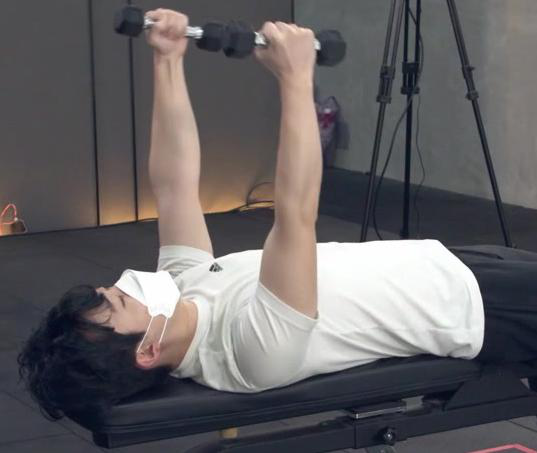

In [5]:
Image.open('data/box1/train_imgs/634-2-4-30-Z148_B-0000007.jpg')

box가 잘 안되는 녀석이 종종 있음 --> box를 더 학습해야 함.

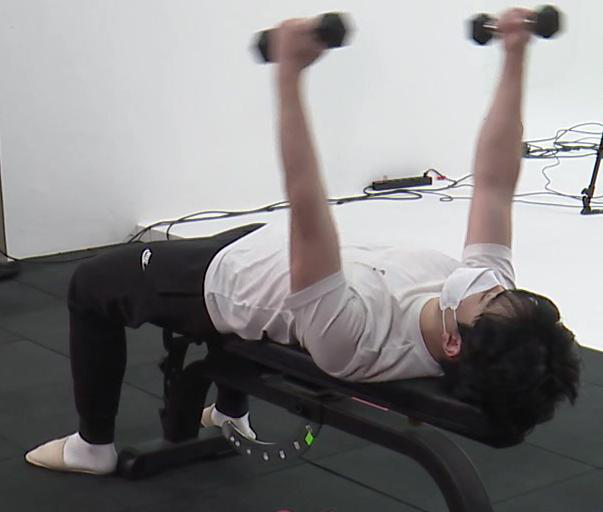

In [6]:
Image.open('data/box1/train_imgs/634-2-4-30-Z148_A-0000007.jpg')

그리고 이 사진 보면 horizontal flip 잘 동작할거같은데??